## Neuromatch Academy 2020 -- Bayes Day (dry run)
# Tutorial 3 - Bayesian decision theory & Cost functions

Please execute the cell below to initialize the notebook environment

In [1]:
# @title

import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
import matplotlib as mpl
from IPython import display        
from scipy.optimize import minimize

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')
mpl.rc('figure', max_open_warning = 0)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
### Tutorial Objectives

In this notebook we'll have a look at the impact of different cost functions (0-1 Loss, Absolute Error, and Mean Squared Error) on Bayesian Decision Theory.

Particularly, we will implement the following cost functions:
  - the Mean Squared Error
  - the Zero-One Loss 
  - the absolute error
  
and we will compare these to the mean, mode and median of our posterior distribution.


---
### EXERCISE 1: Calculate the posterior from a Gaussian Likelihood and Mixture of Gaussians Prior
   
We now want to create a prior matrix that is the result of a mixture of gaussians.

We provide you with `my_gaussian` functions, and a code skeleton to plot the resulting prior

**Suggestions**

  Using the equation for the un-normalised Gaussian `my_gaussian`:
* Generate a Gaussian with mean 0 and standard deviation 0.5
* Generate another Gaussian with mean 0 and standard deviation 3
* Combine the two Gaussians to make a new prior by adding the two Gaussians together with mixing parameter $\alpha$ = 0.05. Make it such that the peakier Gaussian has 95% of the weight (don't forget to normalize afterwards)
* Generate a Likelihood with mean -2.7 and standard deviation 1
* Compute the Posterior using Bayes rule
* Plot the resulting Prior, Likelihood and Posterior using the plotting code snippet already provided

In [2]:
def my_gaussian(x_points, mu, sigma):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns un-normalized Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`

  Args : 
    x_points (numpy array of floats) - points at which the gaussian is evaluated
    mu (scalar) - mean of the Gaussian
    sigma (scalar) - std of the gaussian

  Returns:
    (numpy array of floats): un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  return np.exp(-(x_points-mu)**2/(2*sigma**2))

x=np.arange(-5,5,0.01)

###############################################################################
## Insert your code here to:
##        Create a Gaussian prior made of two Gaussian
##        Both with mean 0 and std 0.5 and 3 respectively
##        Make the combined prior (made of the two Gaussians) by weighing it
##        using a mixing parameter alpha = 0.05 such that the peakier Gaussian has
##        weight 0.95
##        Implement a likelihood with mean -2.7 and standard deviation 1
##        Calculate the posterior using Bayes rule
##        Use the code snippet provided to plot the functions
###############################################################################

# prior_combined = ...

# likelihood = ...

# posterior = ...

# plt.figure
# plt.plot(x, prior_combined, '-r', linewidth=2, label='Prior')
# plt.plot(x, likelihood, '-b', linewidth=2, label='Likelihood')
# plt.plot(x, posterior, '-g', linewidth=4, label='Posterior')
# plt.legend()
# plt.show()

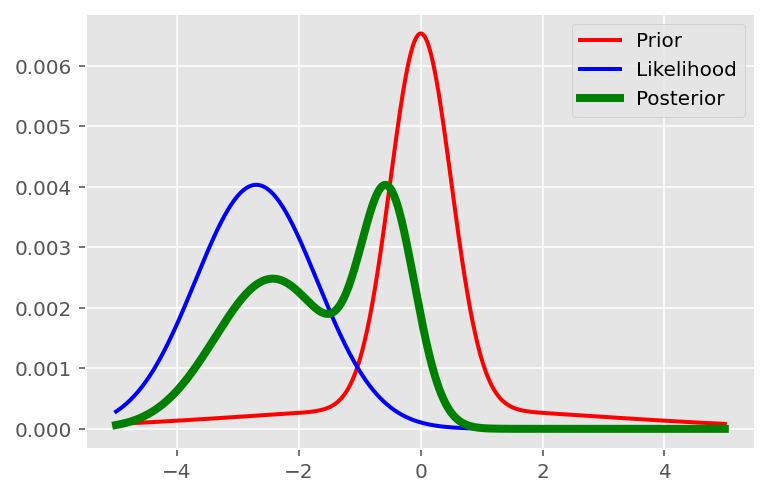

In [3]:
#############
## Solution
#############

x=np.arange(-5,5,0.01)

prior_mean = 0
prior_sigma1  = .5
prior_sigma2  = 3
prior1 = my_gaussian(x, prior_mean, prior_sigma1)
prior2 = my_gaussian(x, prior_mean, prior_sigma2)

alpha = 0.05
prior_combined = (1-alpha) * prior1 + (alpha * prior2)
prior_combined = prior_combined / np.sum(prior_combined)

likelihood_mean = -2.7
likelihood_sigma  = 1
likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
likelihood = likelihood / np.sum(likelihood)

posterior = prior_combined * likelihood
posterior = posterior / np.sum(posterior)

plt.figure()
plt.plot(x, prior_combined, '-r', linewidth=2, label='Prior')
plt.plot(x, likelihood, '-b', linewidth=2, label='Likelihood')
plt.plot(x, posterior, '-g', linewidth=4, label='Posterior')
plt.legend()
plt.show()

---
### EXERCISE 2: Compute and compare the different Loss functions
    
We now want to calculate the expected Loss for different loss functions, and compare these to the mean, median and mode of the posterior we calculated above.

As a reminder, the loss functions are defined as follows:

\begin{eqnarray}
    \text{MeanSquaredError} = (\hat{x} - x)^2
\end{eqnarray}

\begin{eqnarray}
    \text{AbsoluteError} = |\hat{x} - x|
\end{eqnarray}

\begin{eqnarray}
    \text{ZeroOneError} = \begin{cases}
    0,& \text{if } \hat{x} = x\\
    1,              & \text{otherwise}
\end{cases}
\end{eqnarray}

and the Expected Loss is:

\begin{eqnarray}
    \mathbb{E}[\text{Loss}] = \int L[\hat{x},x] \odot  p(x|\tilde{x}) dx
\end{eqnarray}

where $L[\hat{x},x]$ is the loss function, and $p(x|\tilde{x})$ is the posterior computed in exercise 1.

**Suggestions**

  - Calculate the Mean Squared Error (MSE) Loss between x_hat estimate & all x values
  - Compute the Expected MSE Loss ($\mathbb{E}[MSE Loss]$) using your posterior & your MSE Loss (Marginalize)
  - Calculate the Absolute Error Loss between $\hat x$ estimate & all $x$ values
  - Compute the Expected Absolute Error Loss ($\mathbb{E}[Abs E. Loss]$) using your posterior & your Absolute Error Loss (Marginalize)
  - Calculate the Zero-One Loss between x_hat estimate & all x values (use `np.isclose()` to compare $\hat x$ to $x$)
  - Compute the Expected Zero-One Loss ($\mathbb{E}[01 Loss]$) using your posterior & your Zero-One Loss (Marginalize)
  - Calculate the x position that minimizes the Expected Loss for MSE, Absolute Loss, and ZeroOne Loss

  What do you conclude when comparing the mean, median, and mode of your posterior to the minimized cost functions?

In [4]:
def moments_myfunc(x_points, function):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Returns the mean, median and mode of an arbitrary function

    Args : 
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

    Returns:
    (tuple of 3 scalars): mean, median, mode
    """

    # Calc mode of arbitrary function
    mode = x_points[np.argmax(function)]

    # Calc mean of arbitrary function
    mean = np.sum(x_points * function)

    # Calc median of arbitrary function
    cdf_function = np.zeros_like(x_points)
    accumulator = 0
    for i in np.arange(x.shape[0]):
        accumulator = accumulator + function[i]
        cdf_function[i] = accumulator
    idx = np.argmin(np.abs(cdf_function - 0.5))
    median = x_points[idx]

    return mean, median, mode

x=np.arange(-5,5,0.01)

mean, median, mode = moments_myfunc(x, posterior)
print(f"Posterior mean is : {mean:.2f}, Posterior median is : {median:.2f}, Posterior mode is : {mode:.2f}")

ExpectedLoss_MSE = np.zeros_like(x)
ExpectedLoss_Abse= np.zeros_like(x)
ExpectedLoss_01  = np.zeros_like(x)

###############################################################################
## Complete the code below to:
##        Calculate the Mean Squared Error (MSE) Loss between x_hat estimate & all x values
##        Compute the Expected MSE Loss using your posterior & your MSE Loss (Marginalize)
##      
##        Calculate the Absolute Error Loss between x_hat estimate & all x values
##        Compute the Expected Absolute Error Loss using your posterior & your Absolute Error Loss (Marginalize)
##        
##        Calculate the Zero-One Loss between x_hat estimate & all x values (use np.isclose() to compare and fine x_hat == x)
##        Compute the Expected Zero-One Loss using your posterior & your Zero-One Loss (Marginalize)
##        
##        Calculate the x position that minimizes the Expected Loss for MSE, Absolute Loss, and ZeroOne Loss
##        What do you conclude when comparing the mean, median, and mode of your posterior to the minimized cost functions?
###############################################################################

# # Looping over potential x_hats ('decisions')
# for idx in np.arange(x.shape[0]):
#   estimate = x[idx] #This is you current x_hat estimate for which you want to estimate the Expected Loss

#   MSELoss = ... #Calculate the Mean Squared Error Loss between estimate & x
#   ExpectedLoss_MSE[idx] = ...

#   AbsELoss = ... #Calculate the Absolute Error Loss between estimate & x
#   ExpectedLoss_Abse[idx] = ...

#   ZeroOneLoss = ... #Calculate the 0-1 Loss between estimate & x
#   ExpectedLoss_01[idx] = ...

# min_MSE = ...
# min_Abse = ...
# min_01 = ...

# print(f"Minimum of MSE is : {min_MSE:.2f}, Minimum of Abs_error is : {min_Abse:.2f}, Minimum of 01_loss is : {min_01:.2f}")

# # Plotting snippet
# fig, ax = plt.subplots(2,figsize=(13,13), sharex=True)
# ax[0].plot(x, ExpectedLoss_MSE, '-r', linewidth=2, label='Mean Squared Error')
# ax[0].axvline(min_MSE, ls='dashed', color='red', label='Min MSE')
# ax[0].plot(x, ExpectedLoss_Abse, '-b', linewidth=2, label='Absolute Error')
# ax[0].axvline(min_Abse, ls='dashdot', color='blue', label='Min Abs_error')
# ax[0].plot(x, ExpectedLoss_01, '-g', linewidth=4, label='Zero One Loss')
# ax[0].axvline(min_01, ls='dotted', color='green', label='Min 01_Loss')
# ax[0].set_ylabel('Error Loss')
# ax[0].set_xlabel('Orientation (Degrees)')
# ax[0].legend()

# ax[1].plot(x, prior_combined, '-r', linewidth=2, label='Prior')
# ax[1].plot(x, likelihood, '-b', linewidth=2, label='Likelihood')
# ax[1].plot(x, posterior, '-g', linewidth=4, label='Posterior')
# ax[1].axvline(mean, ls='dashed', color='red', label='Mean')
# ax[1].axvline(median, ls='dashdot', color='blue', label='Median')
# ax[1].axvline(mode, ls='dotted', color='green', label='Mode')
# ax[1].set_ylabel('Probability')
# ax[1].set_xlabel('Orientation (Degrees)')
# ax[1].legend()
# plt.show()

Posterior mean is : -1.65, Posterior median is : -1.50, Posterior mode is : -0.58


Posterior mean is : -1.65, Posterior median is : -1.50, Posterior mode is : -0.58
Minimum of MSE is : -1.65, Minimum of Abs_error is : -1.49, Minimum of 01_loss is : -0.58


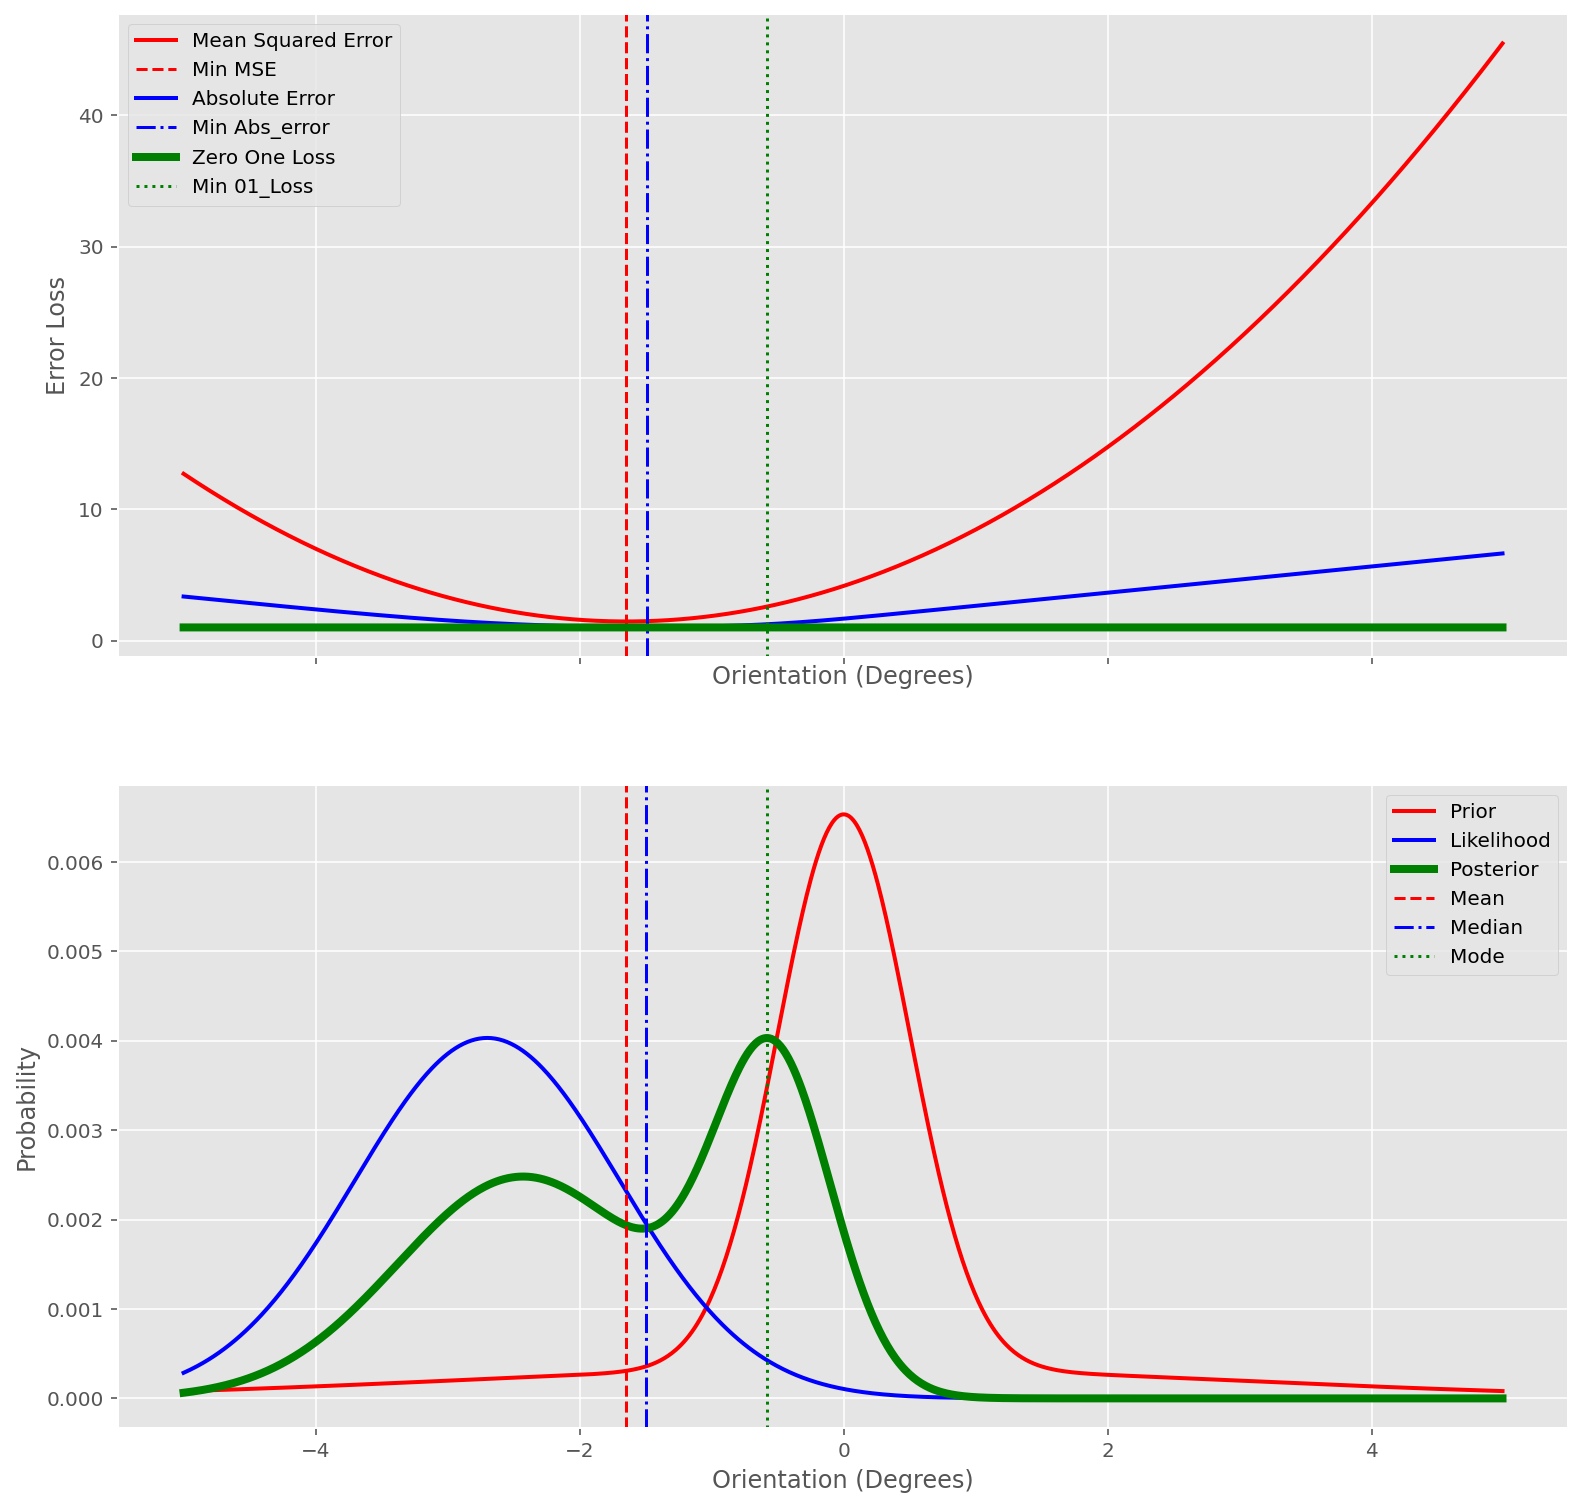

In [5]:
#############
## Solution
#############

x=np.arange(-5,5,0.01)

mean, median, mode = moments_myfunc(x, posterior)
print(f"Posterior mean is : {mean:.2f}, Posterior median is : {median:.2f}, Posterior mode is : {mode:.2f}")

ExpectedLoss_MSE = np.zeros_like(x)
ExpectedLoss_Abse= np.zeros_like(x)
ExpectedLoss_01  = np.zeros_like(x)

for idx in np.arange(x.shape[0]):
    estimate = x[idx]

    MSELoss = (estimate-x)**2
    ExpectedLoss_MSE[idx] = np.sum(MSELoss * posterior)

    AbsELoss = np.abs(estimate-x)
    ExpectedLoss_Abse[idx] = np.sum(AbsELoss * posterior)

    ZeroOneLoss = (~(np.isclose(estimate,x))*1)
    ExpectedLoss_01[idx] = np.sum(ZeroOneLoss * posterior)

min_MSE = x[np.argmin(ExpectedLoss_MSE)]
min_Abse = x[np.argmin(ExpectedLoss_Abse)]
min_01 = x[np.argmin(ExpectedLoss_01)]

print(f"Minimum of MSE is : {min_MSE:.2f}, Minimum of Abs_error is : {min_Abse:.2f}, Minimum of 01_loss is : {min_01:.2f}")

# Plotting snippet
fig, ax = plt.subplots(2,figsize=(13,13), sharex=True)
ax[0].plot(x, ExpectedLoss_MSE, '-r', linewidth=2, label='Mean Squared Error')
ax[0].axvline(min_MSE, ls='dashed', color='red', label='Min MSE')
ax[0].plot(x, ExpectedLoss_Abse, '-b', linewidth=2, label='Absolute Error')
ax[0].axvline(min_Abse, ls='dashdot', color='blue', label='Min Abs_error')
ax[0].plot(x, ExpectedLoss_01, '-g', linewidth=4, label='Zero One Loss')
ax[0].axvline(min_01, ls='dotted', color='green', label='Min 01_Loss')
ax[0].set_ylabel('Error Loss')
ax[0].set_xlabel('Orientation (Degrees)')
ax[0].legend()

ax[1].plot(x, prior_combined, '-r', linewidth=2, label='Prior')
ax[1].plot(x, likelihood, '-b', linewidth=2, label='Likelihood')
ax[1].plot(x, posterior, '-g', linewidth=4, label='Posterior')
ax[1].axvline(mean, ls='dashed', color='red', label='Mean')
ax[1].axvline(median, ls='dashdot', color='blue', label='Median')
ax[1].axvline(mode, ls='dotted', color='green', label='Mode')
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('Orientation (Degrees)')
ax[1].legend()
plt.show()